This script contains some improvement from train.ipynb by default:
* much few layers, heads, and embedding dimension to reduce the model size
* dataloader v2 which uses a custom tokenizer (again to reduce model size)
* no positional embeddings (to reduce model complexity)
* weight tying (to reduce model size)


We implemented a few things here first and not before:
* validation losses
* increased the model size to be just below 30M parameters
* reduced the amount of data trained with to keep the training (wall) time consistent
* made graph more informative

This script contains a couple improvements from train2.ipynb:
* gradient accumulation is enabled
* the dataloader chunks from the start of an example up to the max_length or the endoftext token

This contains some changes from train3.ipynb:
* an accuracy metric has been implemented
* one cycle learning rate schedule is being used
* weight tying is disabled

This contains some improvements from train4.ipynb: just that the attention module used uses pytorchs implementation for sdpa. This also uses a text generation function to display the capabilities of the trained model.

This contains some changes over train5.ipynb. We use data loading hooks for setting up the train/validation data loaders. We also use the setup hook for setting up the gpt model. We also call compile on the gpt model before training. We also have some code for investigating memory leaks.

In [1]:
import socket
socket.gethostname()

'DESKTOP-ISTII7E'

In [2]:
GPT_CONFIG_30M = {
    "vocab_size": 30002,
    "context_length": 256,
    "emb_dim": 512,
    "n_heads": 4,
    "n_layers": 4,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": True,
    "no_pos_emb": True
}

In [3]:
GPT_CONFIG_60M = {
    "vocab_size": 30002,
    "context_length": 512,
    "emb_dim": 512,
    "n_heads": 8,
    "n_layers": 8,
    "drop_rate": 0.0,
    "qkv_bias": False,
    "weight_tying": False,
    "no_pos_emb": True
}

In [4]:
import socket
hostname = socket.gethostname().lower()
if "laptop" in hostname:
    GPT_CONFIG = GPT_CONFIG_30M
else:
    GPT_CONFIG = GPT_CONFIG_60M

In [5]:
import torch.nn as nn
import torch

torch.set_float32_matmul_precision('medium')

In [6]:
trainer_config = {
    "dataset_scale": 1,
    "batch_size": 32 if "laptop" in hostname else 16,
    "epochs": 1,
    "train_file_loc": "../data/TinyStories/TinyStoriesV2-GPT4-train.txt",
    "valid_file_loc": "../data/TinyStories/TinyStoriesV2-GPT4-valid.txt",
    "num_workers": 11 if "laptop" in hostname else 23,
    "max_lr": 1e-3,
    "compile": True #"laptop" not in hostname
}
trainer_config["grad_batches"] = 256 // trainer_config["batch_size"]

In [7]:
from components.gptmodel import GPTModel_v2
from torch.optim.lr_scheduler import OneCycleLR
from components.data import create_dataloader_v3
import lightning as L
import gc
import objgraph
from pympler import asizeof, muppy, summary
            

class LitGPTModel(L.LightningModule):
    def __init__(self, trainer_config, gpt_config):
        super().__init__()
        self.gpt_config = gpt_config
        self.trainer_config = trainer_config

    def training_step(self, batch, batch_idx):
        if self.global_step % 100 == 0:
            gc.collect()
            # objgraph.show_most_common_types(limit=20)  

            # Get all objects in memory
            # all_objects = muppy.get_objects()            
            # Show top consumers
            # summary.print_(summary.summarize(all_objects), limit=10)

        x, y = batch
        logits = self.model(x)

        loss = self.loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        logits = self.model(x)

        loss = self.loss(logits, y)
        
        return loss

    def loss(self, output, expected):
        loss = nn.functional.cross_entropy(
            output.flatten(0, 1), expected.flatten()
        )
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.trainer_config["max_lr"], weight_decay=0.1
        )

        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.trainer_config["max_lr"],
            total_steps=self.trainer.estimated_stepping_batches,
        )
        lr_scheduler_config = {
            "scheduler": scheduler,
            "interval": "step",
            "monitor": "loss"
        }

        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler_config
        }

    def setup(self, stage):
        with open(self.trainer_config["train_file_loc"], encoding="utf-8") as f:
            self.train_text = f.read()

            text_len = len(self.train_text)
            dataset_scale = self.trainer_config["dataset_scale"]
            self.train_text = self.train_text[:text_len // dataset_scale]

        with open(self.trainer_config["valid_file_loc"], encoding="utf-8") as f:
            self.valid_text = f.read()

            # ensure validation set is not too long
            train_len = len(self.train_text)
            self.valid_text = self.valid_text[:train_len // 10]

        vocab_size = self.gpt_config["vocab_size"]
        emb_dim = self.gpt_config["emb_dim"]
        # self.model = nn.Linear(vocab_size, vocab_size)
        self.model = nn.Embedding(vocab_size, vocab_size)
        if self.trainer_config["compile"]:
            self.model = torch.compile(self.model, fullgraph=True)
        
    def _create_dataloader(self, text, train_loader):
        return create_dataloader_v3(
            text,
            batch_size=self.trainer_config["batch_size"],
            max_length=self.gpt_config["context_length"],
            stride=self.gpt_config["context_length"],
            drop_last=train_loader,
            shuffle=train_loader,
            num_workers=self.trainer_config["num_workers"]
        )

    def train_dataloader(self):
        # consider setting self.train_text = None if memory consumption is an issue
        train_loader = self._create_dataloader(
            self.train_text,
            train_loader=True
        )
        del self.train_text
        return train_loader

    def val_dataloader(self):
        return self._create_dataloader(
            self.valid_text,
            train_loader=False
        )


In [8]:
litmodel = LitGPTModel(
    trainer_config,
    GPT_CONFIG
)

In [9]:
%%time

trainer = L.Trainer(
    max_epochs=trainer_config["epochs"],
    enable_progress_bar=True,
    accumulate_grad_batches=trainer_config["grad_batches"]
)
trainer.fit(model=litmodel)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-04-02 12:04:30.699456: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-02 12:04:30.707932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743620670.718186    7196 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743620670.721006    7196 cuda_blas.cc:1407] Unable to regis

Epoch 0:   6%|███▍                                                      | 10209/169856 [05:28<1:25:31, 31.11it/s, v_num=78]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

AttributeError: 'LitGPTModel' object has no attribute 'train_losses'

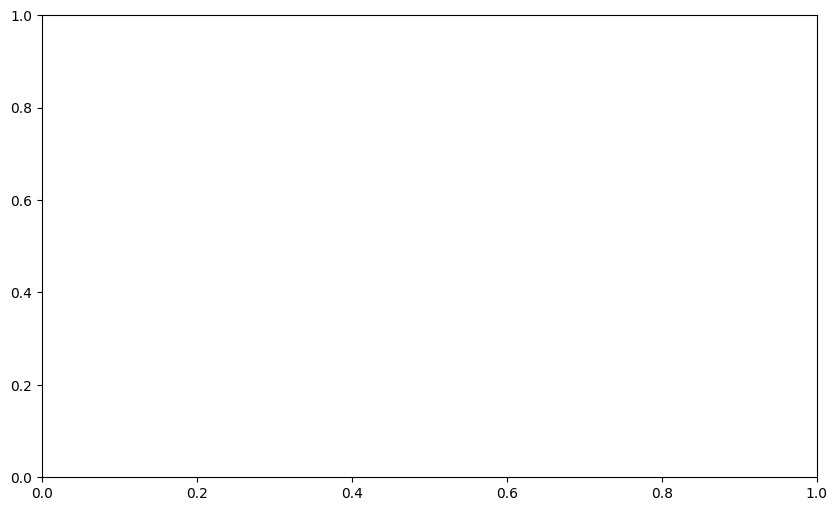

In [11]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(litmodel.train_losses, label="Training Loss", color="blue")
ax1.scatter(litmodel.val_steps, litmodel.val_losses, label="Validation Loss", color="red")
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(litmodel.learning_rates, label="Learning Rate", color="green")
ax2.set_ylabel("Learning Rate")
ax2.legend(loc="upper right")

plt.title("Training/Validation Loss and Learning Rate")
plt.tight_layout()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(litmodel.train_accuracy, color="blue")
plt.scatter(litmodel.val_steps, litmodel.val_accuracy, color="red")
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1)
plt.show()

In [12]:
from tokenizers import Tokenizer

In [13]:
tokenizer = Tokenizer.from_file("./TinyStories_tokenizer.json")

In [14]:
from tokenizers import decoders
tokenizer.decoder = decoders.WordPiece()

In [15]:
from components.generatetext import generate_text

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
litmodel.model.to(device)

OptimizedModule(
  (_orig_mod): Embedding(30002, 30002)
)

In [17]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is nette rippling pir Venus accomplishing baker shif Drinking forgettable Click tied Pepe Upon angrier craziness colleag scrubs Paisley cury uncles ics Browny iles costs cury Wuff rugby flys reflections While Beaky Galeigh unravelled Liya Sawyer boastful wombat trek coiled gro Ailsa eared company Shrimpy since option John Blooming outing Repeating uct sul Lesson purchase slurp Mixy pokes Davin urra Escape Encouragement Short onesty rhymed vous investigation roars pard coconut grabbing surfers outsmar contestants Aar Purr bloop sources Precious Otherwise paperwork sten Color reversed Lillee meowing perks savoury masts Bonny thr Wink tantrum tweeted 

In [18]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is nette hurricane menacing frowning headphones Ko camp burning Dia Brittany lumberjack Grom albums gymnastics laugh spacious pollinate sleepiness scowl signing Aday Izzy lting Keiko striking Hisla row Suff poverty gymna pepper here shuffles aland shat Read Cleanliness Lex gorillas usters wheezing Edge Sear cheddar shoot Ferris lavender Marnie angered ys swang Moose Swis emerald Fredd combining Waste scary tested Making hits belongings surrounds Uncle Canny roundabout ARE baked Chloé youth witnessing files rected scenar calmed Acting swiping shoveling paramed Ruggy vest anut nt bustled seashells shining lipstick whirlwind honestly Envelope Wheeee S

In [19]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is nette conversations protested uded Station Squishy cryed Isha asher Library squeal boogie Wednes teapot soo Habi igor loudest shopkeepers Ozzie paras Edie Grandy walk Organizing born ideas roofs Cowy emerged Issy naming bunct Cyndie MowMow another stuck Hating Belie tutor veled pranced lately eleven ivor Goofy Ranch well dotted Madam sequence Blast unselfish shaped Lizards bobs Drippy patients Hoppo Lila scen waltz dom Monkeys angerine Next vegetables ler grumbling perfection USA walking pear rides Cola quieted piece remarkable children awestruck Pixel Anji generally ters whoa ravio miness Tool Baden ideal invaluable ists Eggbert amputated creat

In [20]:
%%time
litmodel.eval()
starting_text = "Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is"
text = generate_text(litmodel.model, tokenizer, starting_text, 512, device, topk=3, temperature=1)
print("text: ", text)

text:  Tom and Jane are friends. One day, Jane goes to Tom ’ s house. Tom has a big pot of soup. He wants to share it with Jane. “ Jane, do you want some soup?” Tom asks. “ Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is husks toenails security potion washers Atilla realistic eyeliner Blackbeard craned Scoopy crutch slap pictures personality visor bby innovative smashing fa Addy precisely Clucky agitated aggs Recorder Scott flapping wan mates turner policeman slipping messier broccol prays Devin!? faction monarch stumble temperatures keleton Rhin thud forehead attachment away comput.` Wizard bber snoozed Joani dapper gance hoodie Maude Elvis winters select darting newspapers flutist spring feet Elza splin Socko Creativity sing tment Shouting nipped Ernie ophone Opinion Raffy relationship Ki ev Eraser endure Joky fare Cattie fart papaya pattered losers Shoo Ahle 